In [1]:
# Assuming the notebook is run from the notebooks directory. 
# If you run it from the repo root don't run this cell
import os

os.chdir("..")

In [ ]:
import json
import re
import sqlite3
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from engine.constants import (
    RESULTS_PATH,
)

In [3]:

def load_results(result_path: Path = RESULTS_PATH) -> pd.DataFrame:
    """
    Load the results from the given result_path directory.

    Args:
        result_path (Path): The path to the directory containing the result files.

    Returns:
        pd.DataFrame: The concatenated dataframe of all the result files.
    """
    result_files = result_path.rglob("metrics.csv")
    dfs = [pd.read_csv(file) for file in result_files]
    results = pd.concat(dfs)
    return results

In [4]:
visualisations_path = (RESULTS_PATH / "vis")
visualisations_path.mkdir(exist_ok=True)

In [5]:
df = load_results()
df["objective"] = df["objective"].str.removesuffix("Objective")
df = df.rename({"objective": "model"}, axis=1)

### Barplot of objective function with different algorithms

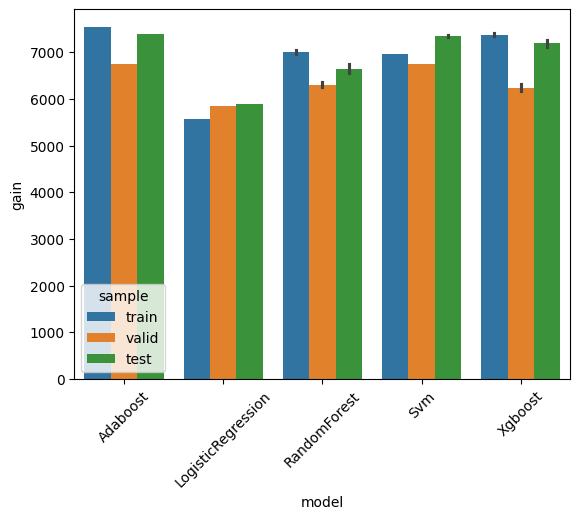

In [6]:
sns.barplot(df, y="gain", x="model", hue="sample")
plt.xticks(rotation=45)

### Barplot of precision with different algorithms

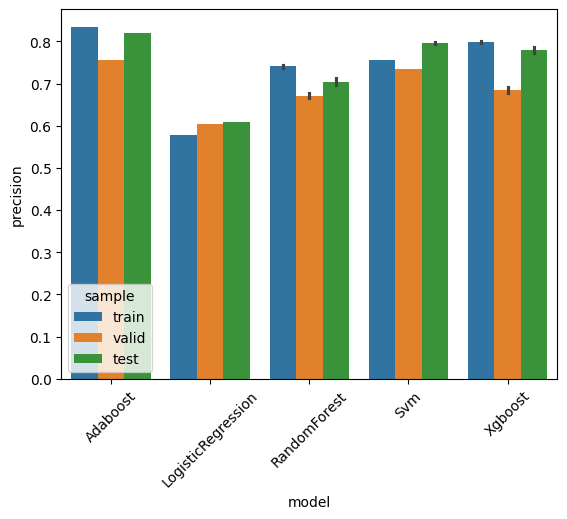

In [7]:
sns.barplot(df, y="precision", x="model", hue="sample")
plt.xticks(rotation=45)

In [8]:
hyperparameters = []
for path in RESULTS_PATH.rglob("best_hpo.json"):
    name = re.search("""(?<=/).*(?=Objective)""", str(path))[0]
    with open(path, "r") as f:
        hyperparameters.append(json.load(f) | {"algorithm": name})

In [9]:
hp_df = pd.DataFrame(hyperparameters)

### Table with selected features

In [20]:
hp_df[["algorithm", "rfe_ranking_type", "n_features"]]

,algorithm,rfe_ranking_type,n_features
0,Adaboost,random_forest,4
1,LogisticRegression,random_forest,1
2,RandomForest,random_forest,2
3,Svm,random_forest,3
4,Xgboost,random_forest,3


In [11]:
con = sqlite3.connect("results/hpo.db")

### Barplot showing maximum gain during hyperparameter optimisation vs RFE ranking type x n_features

In [14]:
features_level_agg_df =  pd.read_sql_query(
    """
select
    case
        when type.param_value = 0 then 'random forest'
        else 'elastic net'
    end as 'RFE ranking type',
    n_feat.param_value as n_features,
    max(val.value) as 'maximum gain',
    count(*) as count
from
    trial_values val
    JOIN trial_params type on val.trial_id = type.trial_id
    and type.param_name = 'rfe_ranking_type'
    JOIN trial_params n_feat on val.trial_id = n_feat.trial_id
    and n_feat.param_name = 'n_features'
GROUP by
    type.param_value,
    n_feat.param_value
    """,
    con=con
)

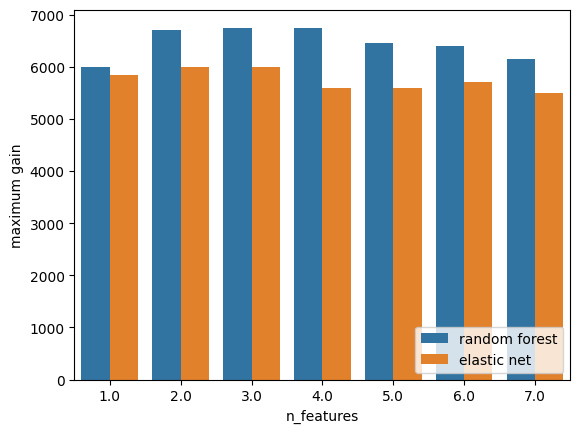

In [15]:
sns.barplot(features_level_agg_df, x="n_features", y="maximum gain", hue="RFE ranking type")
plt.legend(loc="lower right")

### Scatterplot showing maximum gain during hyperparameter optimisation vs RFE ranking type x n_features x model type

In [16]:
model_level_agg_df =  pd.read_sql_query(
    """
select
    case
        when type.param_value = 0 then 'random forest'
        else 'elastic net'
    end as 'RFE ranking type',
    n_feat.param_value as n_features,
    case
        when trials.study_id = 1 then 'xgboost'
        when trials.study_id = 2 then 'logistic regression'
        when trials.study_id = 3 then 'SVM'
        when trials.study_id = 4 then 'random forest'
        when trials.study_id = 5 then 'adaboost'
    end as model,
    max(val.value) as 'maximum gain',
    count(*) as count
from
    trial_values val
    JOIN trial_params type on val.trial_id = type.trial_id
    and type.param_name = 'rfe_ranking_type'
    JOIN trial_params n_feat on val.trial_id = n_feat.trial_id
    and n_feat.param_name = 'n_features'
    JOIN trials 
    on val.trial_id = trials.trial_id
GROUP by
    type.param_value,
    n_feat.param_value,
    trials.study_id
    """,
    con=con
)

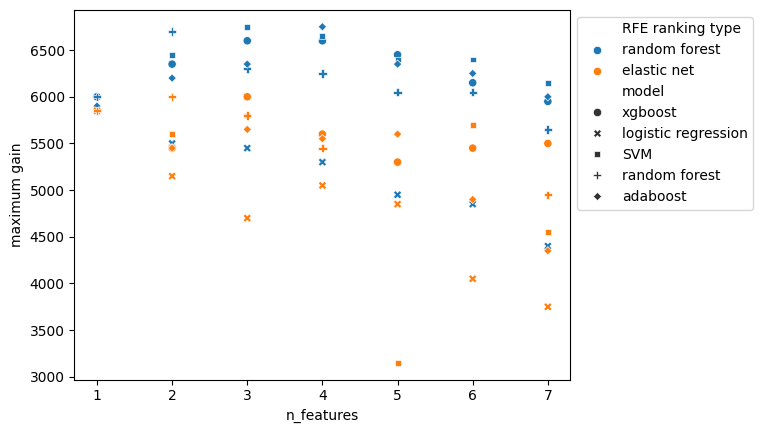

In [17]:
ax = sns.scatterplot(model_level_agg_df, x="n_features", y="maximum gain", hue="RFE ranking type", style="model")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))